<a href="https://colab.research.google.com/github/x8BADF00D/edgeai_thermostat/blob/main/sinewave_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import layers

In [ ]:
# print versions
!python --versions
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

unknown option --versions
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.
Numpy 1.19.5
TensorFlow 2.4.1
Keras 2.4.0


In [ ]:
# Settings for dataset creation and allocation
nsamples = 1000         # Number of samples in dataset
val_ratio = 0.2         # Percentage of samples that should be held for validation
test_ratio = 0.2        # Percentage o fsamples that should be held for test set

# names we'll use later for files
tflite_model_name = 'sine_model'  # will be given .tflite suffix
c_model_name = 'sine_model'       # will be given .h suffix

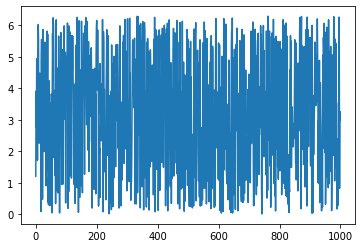

In [ ]:
# Creating input data, numbers between 0 and 2pi
# Generate some random samples
np.random.seed(1234)
x_values = np.random.uniform(low=0, high=(2 * math.pi), size=nsamples)
plt.plot(x_values)

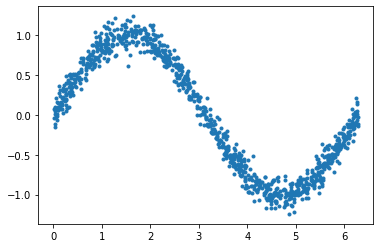

In [ ]:
# creating the output data using the input data we just made
# create a noisy sinewave with these values
y_values = np.sin(x_values) + (0.1 * np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')

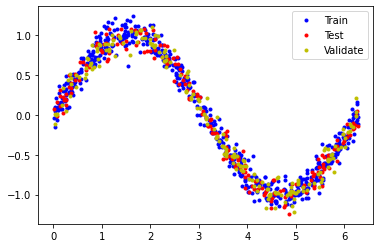

In [ ]:
# Split the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

In [ ]:
# 2 layers, then output layer
# Create a model
# We'll adapt this section to input our thermostat data
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))    # input layer; relu = rectified linear unit
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))    # Output layer

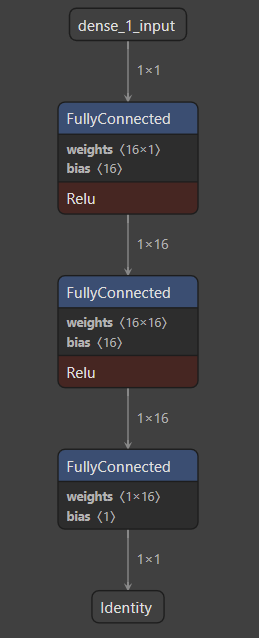

In [ ]:
# View model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Add optimizer, loss function, and metrics to model and compile it
# there are other optimizers and loss functions
# might change this section too
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

In [ ]:
# Train model
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val,y_val))

Epoch 1/500
6/6 [==============================] - 1s 69ms/step - loss: 0.8032 - mae: 0.8032 - val_loss: 0.7432 - val_mae: 0.7432
Epoch 2/500
6/6 [==============================] - 0s 8ms/step - loss: 0.7361 - mae: 0.7361 - val_loss: 0.6699 - val_mae: 0.6699
Epoch 3/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6492 - mae: 0.6492 - val_loss: 0.6083 - val_mae: 0.6083
Epoch 4/500
6/6 [==============================] - 0s 8ms/step - loss: 0.6082 - mae: 0.6082 - val_loss: 0.5628 - val_mae: 0.5628
Epoch 5/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5664 - mae: 0.5664 - val_loss: 0.5394 - val_mae: 0.5394
Epoch 6/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5590 - mae: 0.5590 - val_loss: 0.5164 - val_mae: 0.5164
Epoch 7/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5444 - mae: 0.5444 - val_loss: 0.4986 - val_mae: 0.4986
Epoch 8/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5166 - mae: 0.5166 - va

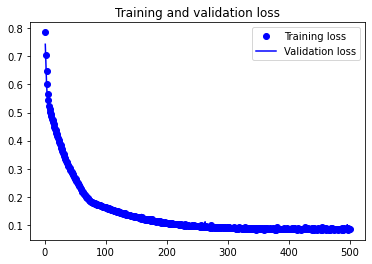

In [ ]:
# Plot the training history
# just graphing some stuff
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

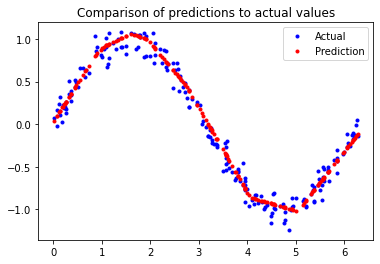

In [ ]:
# Plot predictions against actual values
# just graphing more stuff
predictions = model.predict(x_test)

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Prediction')
plt.legend()
plt.show()

In [ ]:
#####################################################################
# Takes Keras model and converts it to TFL model for use on arduino #
#####################################################################

# Convert Keras Model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9n7wu3c3/assets


2992

In [ ]:
###################################################
# This section converts tflite model into C array #
###################################################

# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [ ]:
###################################################
# Convert C array into .h file for use in arduino #
###################################################

# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))